### Analyzing Credit Card Agreements Using NLP

The purpose of this project is to take a legal document, like a contract, model the topics and create a pipeline to tag parts of the document with a relevant label. This notebook will focus on the the preprocessing of the data, the topic modeling and the creation of the training set. Ultimately the code in this repo will be useful for people who want to understand a complex legal document such as a credit card agreement more clearly.

The data comes from the following link: https://www.consumerfinance.gov/credit-cards/agreements/

The Consumer Financial Protection Bureau (CFPB) collects credit card agreements from creditors on a quarterly basis and posts them at the link above. The CFPB organizes the data by putting each participating company in a directory and then collecting all the statements in a directory for each company. For Q4 of 2018 there are 652 companies and each company has on average 2-4 agreements. 

For *most* people contract documents are not fun to read because they are usually written in complex legal jargon and the style of writing is purposely dry so as to spell out worst-case scenarios. That said it is important to understand what you or your business is getting into before signing any sort of agreement. Because it takes a certain type of expertise to understand these documents I feel it would be interesting to see if we can leverage natural language techniques to tag this these documents 

##### First steps

Since the documents are in PDF format we have to do some preprocessing to get it into the right format. Our immediate goal is to process the data and use non-negative matrix factorization and word2vec to create a topic coherence model. The next couple cells show the process to take the data, process the pdf's and then get the data ready for tokenization before we throw it into the model. All the preprocessing data can be found in /utils/process_data.py in this project's repo. Since the many of the processes take time to work through the datasets many of the functions output a pkl file to the data directory to speed up the process.

In [6]:
from utils.process_data import Process

In [7]:
import os

DATA_PATH = './data/cc_2018/'
files = [f for f in os.listdir(DATA_PATH)]
data_init = Process(files, DATA_PATH, 'pdf-output-2.pkl')
OVERWRITE = True

In [8]:
custom_stopwords = ['aaa']

process_val = {'stopwords':'english',
               'custom_sw':custom_stopwords,
               'stemmer':'yes',
               'ngrams':'bigrams'}

temp_ = data_init.remove_lines(OVERWRITE, data_init, **process_val)

file exists, loading data...
loaded...


##### Tokenization of the features 

We run the preprocessed data through the tfidf tokenizer and output a document-term matrix. The matrix has 48k+ documents and 3234 terms. Max_df and min_df were set to 0.5 and 100 respectively as these parameters were found to be the best.

In [9]:
params = {'vectorizor': 'tfidf',
          'max_df': .5,
          'min_df': 100,
          'max_features':None 
         }

tfidf = data_init.vectorize(**params)

tfidf

loading data...
loaded...
applying tfidf


<48451x3234 sparse matrix of type '<class 'numpy.float64'>'
	with 1517921 stored elements in Compressed Sparse Row format>

In [10]:
#load terms from previous step

from sklearn.externals import joblib

#load terms from the tfidf tokenizer
_,terms=joblib.load('./data/tfidf-output.pkl')

##### Display top terms by tfidf 

To find the top terms as calculated by tfidf we will sum up each column/term of the document-term matrix (axis=0), pair the terms with the sums, and sort from highest to lowest score. Conveniently sklearn tfidf tokenizer outputs the terms from the get_feature_names() method. We will pair these up using a dictionary. 

Finally we display the top terms in a bar chart below.

In [16]:
import operator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

score = tfidf.sum(axis=0)

tfidf_sorted = sorted({str(t): float(score[0,c]) for c,t in enumerate(terms)}.items(), 
                       key=operator.itemgetter(1),
                       reverse=True)

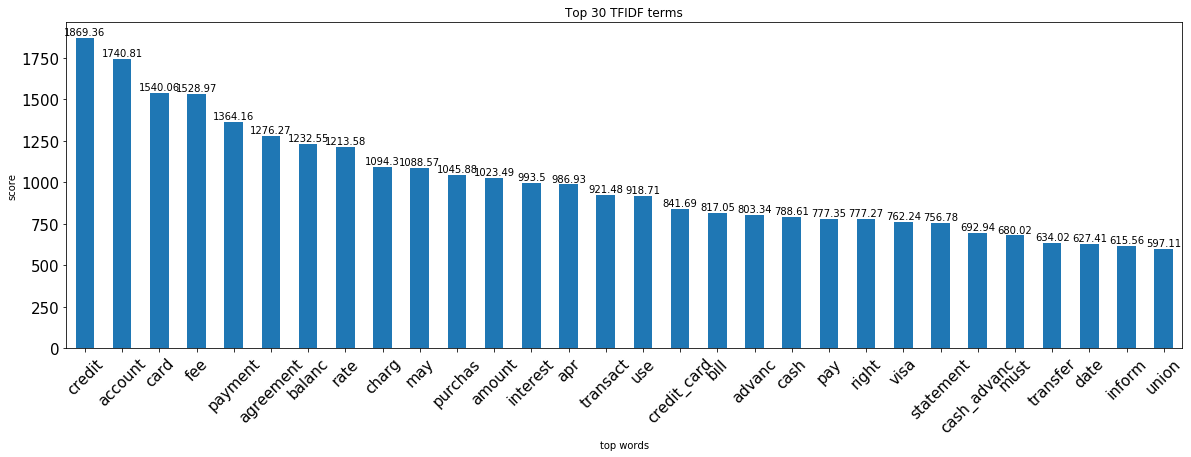

In [59]:
import pandas as pd

x_labels = [val[0] for val in tfidf_sorted[:30]]
y_labels = [round(val[1],2) for val in tfidf_sorted[:30]]

plt.figure(figsize=(20, 6))
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)
plt.title('Top 30 TFIDF terms')
plt.xticks(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('top words')
plt.ylabel('score')

rects = ax.patches

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

As expected terms like credit, agreement, account, card, and fee dominate the corpus, which comes at no suprise as we are reading a credit card agreement. Because we utlimately want to group these terms into labels let's cluster the data so we can see where these terms will fall.

##### Naive clustering approach

Now that we know what the top terms are, let's cluster the data. We will take a naive approach at clustering by assigning the data a set number of clusters. For this portion we will use kmeans clusters to sort the TFIDF data. This method will output arrays of scores into the number of clusters we assign, from there we will sort each cluster from highest score to lowest, find the indices with argsort, and find the term associated with that indice. Finally we will print out the terms associated.

In [61]:
# KMeans clustering is a method of clustering.
from sklearn.cluster import KMeans

number_of_clusters = 4
km = KMeans(n_clusters=number_of_clusters)
km.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [63]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1] #sort highest to lowest

for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: rate apr prime prime_rate base percentag annual_percentag percentag_rate market_base vari_market
Cluster 1: must error letter receiv_letter bill amount purchas tell right correct
Cluster 2: fee payment balanc charg interest amount minimum interest_charg transfer advanc
Cluster 3: credit card account agreement may use credit_card visa union credit_union


##### Cluster output

Our clusters seem to take shape along some themes. Cluster 0 seems to talk about rates, Cluster 1 looks at errors and billing possibly, Cluster 2 talks about fee payments and interest, and Cluster 3 talks about aggrements and credit. This is a good start but it is not good enough to start labeling. Let's visualize it first to see what our data looks like.

##### Decompose the data using PCA and plot the clusters

In [76]:
from sklearn.decomposition import PCA
reduced_data = PCA(n_components=2).fit_transform(tfidf.todense())

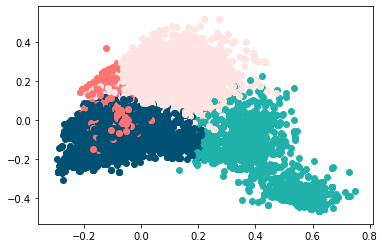

In [79]:
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073'
}

labels = km.labels_

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

As you can see above the data looks pretty but it does not tell us alot about how we should label our data.

##### Topic modeling using non-negative matrix factorization

We will decompose the doc-term matrix into two smaller matrices, W & H, using a technique called Non-Negative Matrix Factorization. The W matrix dimensions are n x k which translates to documents x topics. The H matrix consists of the dimensions k x m which is equivalent to topics x terms. We will look for the value of k (topics) with the highest mean coherence. Coherence can be otherwise stated as the terms that best represent the desired topic.

The dimensions will be for k topics:</br>

matrix W (docs x topics): 48,000 x k </br>
matrix H (topics x terms): k x 3800 </br>

##### Parameters:

NMF will be initiated with singular value decomposition (SVD) with is equivalent to the paramenter 'nnsvd' in sklearn. NMF can be initiated randomly but it will reduce what is called 'stability' model. Meaning that the output of the model (topic coherence) is different each time. 

In [13]:
from sklearn.decomposition import NMF
import pickle

if os.path.exists('./data/nmf-output.pkl') == False:
    print('processing nmf...')
    kmin, kmax = 4,15
    
    print(f'calculating nmf for k {kmin} to {kmax}...')
    d = {}
    for k in range(kmin,kmax+1):
        model = NMF(init='nndsvd', n_components=k) 
        d[k] = model.fit_transform(tfidf), model.components_ #collect W & H factors
    
    print('dumping file to pkl...')
    output = open('./data/nmf-output.pkl', 'wb')
    pickle.dump(d, output)
    output.close()
    print('done')
    
else:
    print('file exists, loading data...')
    
    pkl_file = open('./data/nmf-output.pkl', 'rb')
    d = pickle.load(pkl_file)
    pkl_file.close()
    
    print('loaded...')

processing nmf...
calculating nmf for k 4 to 15...
dumping file to pkl...
done


In [101]:
# import pandas as pd
# df_ = pd.concat([temp_[k] for k in temp_.keys()],axis=0).reset_index().drop(['index'],axis=1)
# l = [df_[0].iloc[x].split(", ") for x in range(652)]

##### Create the word embedding model

Initially we try word2vec as a word embedding model, but through experimentation we find that it delivers a low word output. Because the algorithm works best when we have a fairly large collections of terms we swtiched to a word embedding model called fasttext. Fasttext is a word embedding method developed by facebook and instead of representing a word as a vector, the words are represented as a bag of character n-grams. The word embedding becomes the sum of those n-grams.

In [19]:
import gensim
import pandas as pd

if os.path.exists('./data/w2v-model.bin') == False:
    print('preprocessing text data for w2v model')
    #w2v_raw = data_init.preprocess(temp_['USE Credit Union'], **process_val)
    
    #processed = {k: data_init.preprocess(temp_[k], **process_val) for k in temp_.keys()}
    
    #processed = data_init.remove_lines(OVERWRITE, data_init, **process_val)
    
    df_ = pd.concat([temp_[k] for k in temp_.keys()],axis=0).reset_index().drop(['index'],axis=1)

    w2v_raw = [df_[0].iloc[x].split(", ") for x in range(652)]
        
    #w2v_raw = pd.concat([processed[k] for k in processed.keys()],axis=0).reset_index().drop(['index'],axis=1)

    print('making w2v model')
    w2v_m = gensim.models.Word2Vec(w2v_raw, size=500, min_count=20, sg=1)

    print(f'word2vec model has {len(w2v_m.wv.vocab)} terms')
    w2v_m.save('./data/w2v-model.bin')
    
else:
    print('file exists...')
    w2v_m = gensim.models.Word2Vec.load('./data/w2v-model.bin')
    print(f'word2vec model has {len(w2v_m.wv.vocab)} terms')

preprocessing text data for w2v model
making w2v model
word2vec model has 374 terms


In [20]:
from sklearn.externals import joblib

(tfidf_,terms) = joblib.load('./data/tfidf-output.pkl')

In [23]:
f2t_m = gensim.models.Word2Vec.load('./data/f2t-model.bin')

##### Visualize the best mean coherance score using fasttext for each k 

Below for each topic in all the possible topic models we retrieve the top 10 terms and calculate a mean coherence score from each topic based on our fasttext values. We then graph that out to see which k value has the highest coherence value.

In [24]:
from utils.topic_model import calculate_coherence, top_term

k_values, coherences = [],[]
for k in range(4,15):
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = [top_term(terms, d[k][0], topic_index, 10) for topic_index in range(k)]

    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(f2t_m, term_rankings)) 

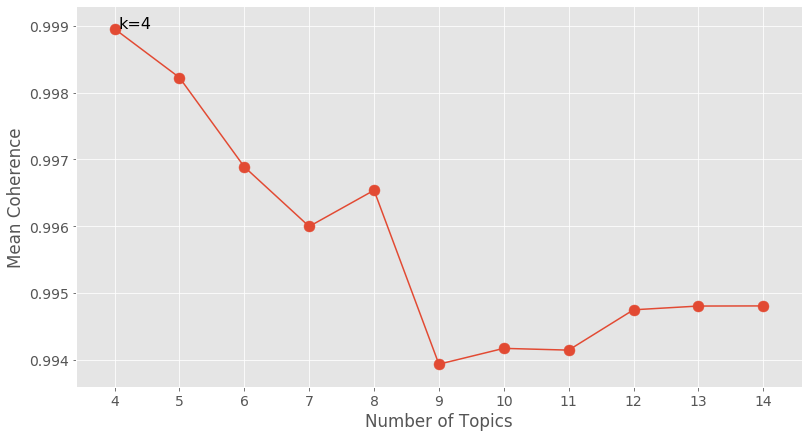

In [25]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot(k_values, coherences)
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

##### Results

We see that our best coherance score comes from k=4. With that said because I want to label the results meaningfully and cluster as such, therefore I will increase the cluster size to 8. My logic is that all the scores are pretty high to begin with and 8 topics seems to be a good trade off between score and information.

##### Print out documents and terms for each topic

In [14]:
import pandas as pd
from itertools import chain

data_ = data_init._iterate()
combined_ = [i for i in chain.from_iterable([data_[i] for i in data_.keys()])]
data = pd.DataFrame(combined_)

In [148]:
from utils.topic_model import get_top_snippets, top_term

d=joblib.load('./data/nmf-output.pkl') #load the nmf output

k = 8
W = d[k][0]
H = d[k][1]


sentences = [headline[0:min(len(headline),100)] for headline in data[0]]
descriptors = [top_term(terms, H, topic_index, 10) for topic_index in range(k)]


hand_label = {}
for i in range(k):
    topic = i
    headlines = 50

    d_ = {i+1: sentences
             for i,sentences in enumerate(get_top_snippets(sentences, W, topic, headlines))
        }
    
    hand_label[i] = pd.DataFrame.from_dict(d_, orient='index').rename(columns={0:'ground_truth',
                                                                               1:'NMF categorized'})
    
    temp_ = pd.DataFrame.from_dict(d_, orient='index').rename(columns={0:'ground_truth',
                                                                       1:'NMF categorized'})

    print('#''='*30)
    print(f'top terms for topic {topic}')
    print(descriptors[topic])

    print('='*50)
    gt_top = temp_['ground_truth'].value_counts().index[0]
    print(f'top ground truth label: {gt_top}')

    print('='*50)
    print(f'top documents for each topic {topic}')
    print(temp_)
    print('')

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
top terms for topic 0
['payment', 'minimum', 'minimum_payment', 'due', 'late', 'payment_due', 'late_payment', 'return', 'statement', 'return_payment']
top ground truth label: Payments  
 
top documents for each topic 0
                                         ground_truth
1                                            PAYMENTS
2                                            Payments
3                                           PAYMENT $
4                                            Payments
5                                        PAYMENTS\n\n
6                                       Payments  \n 
7                                 Your payment. \n\n 
8                                 About your payments
9                                       Payments  \n 
10                                      Payments  \n 
11                                PAYMENTS.   \n\n   
12                                      Payments  \n 
13                

##### Bootstrap - label

Ok now the fun part. We've outputted the top documents (sentences) by our self-created labels. The first step in this process is to create names for those labels. Below are the names that I have determined for each cluster. We will take the sentences that our nmf-ft model outputted and assign labels to them. We will then train that model using a classifier, and then train that on all of the data to create a labelled dataset. From there we will have a trained classifier that will be able to predict on a document that we feed it. To keep it simple for the time being we will predict a label for each sentence in the document. Realistically we know that every sentence is not related to the labels we gave it, and some of the sentences in the beginning and end of the document will not relate, but we can deal with that later. For now let's build a classifier.

##### Create a dataset from the clustered data...

In [149]:
#create a label column right here 

labels = ['payment','rate','agreement','error','fee','purchases','interest','credit_tips']

for k in hand_label.keys():
    hand_label[k]['label'] = labels[k]

In [150]:
#hand_label[0] = hand_label[0].drop(['new_column'],axis=1)

In [151]:
label = ['label']

hl = pd.concat([hand_label[k] for k in hand_label.keys()],axis=0).reset_index().drop(['index'],axis=1)

In [152]:
#train a classifier

hl.head()

,ground_truth,label
0,PAYMENTS,payment
1,Payments,payment
2,PAYMENT $,payment
3,Payments,payment
4,PAYMENTS\n\n,payment


In [143]:
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import bigrams,trigrams

def preprocess(text, **kwargs):
        '''
        Basic NLP preprocessor
        -removes stop words
        -n-grams
        -stem
        -simple gensim preprocessor
        '''

        stopwords_ = kwargs.get('stopwords')
        cust_sw = kwargs.get('custom_sw')
        stemmer = kwargs.get('stemmer')
        ngrams = kwargs.get('ngrams')

        text = text.apply(gensim.utils.simple_preprocess, min_len=3)
        
        sw = set(stopwords.words(stopwords_))
        custom_sw = set(cust_sw)

        if stopwords_: text = text.apply(lambda s: [w for w in s if w not in sw]) 

        if custom_sw: text = text.apply(lambda s: [w for w in s if w not in custom_sw])

        if stemmer=='yes': text = text.apply(lambda s: [SnowballStemmer("english", ignore_stopwords=True).stem(w) for w in s])

        if ngrams=='bigrams': 
            text = text.apply(lambda s: ['_'.join(x) for x in nltk.bigrams(s)] + s)

        elif ngrams=='trigrams':
            text = text.apply(lambda s: ['_'.join(x) for x in nltk.trigrams(s)] + s)

        return text

##### Preprocess the dataset and prepare the data for the training pipeline

In this step we process the data just like we did above before we put it into the pipeline.

In [153]:
#from utils.process_data import preprocess

custom_stopwords = ['aaa']

process_val = {'stopwords':'english',
               'custom_sw':custom_stopwords,
               'stemmer':'yes',
               'ngrams':'bigrams'}


hl['ground_truth'] = preprocess(hl['ground_truth'],**process_val).apply(lambda x:', '.join(map(str, x)))

In [157]:
hl.index

RangeIndex(start=0, stop=400, step=1)

#####  Train the model 

We now pass the preprocessed data through an sklearn pipeline. The pipeline takes care of the preprocessing and our prediction model will be a Multinomial Naive Bayes.

In [159]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X,y = hl['ground_truth'], hl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(X_train,y_train)

import pickle

# filename = 'document_prediction_model.sav'
# joblib.dump(text_clf, './data/' + filename)

y_pred = text_clf.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

  agreement       1.00      1.00      1.00        10
credit_tips       1.00      1.00      1.00         7
      error       1.00      1.00      1.00         5
        fee       1.00      1.00      1.00        12
   interest       0.88      1.00      0.93        14
    payment       1.00      0.91      0.95        11
  purchases       0.90      0.82      0.86        11
       rate       1.00      1.00      1.00        10

avg / total       0.96      0.96      0.96        80



###### Random Forest Model - Grid Search

In [175]:
from scipy.stats import randint 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from time import time
from sklearn.model_selection import LeaveOneGroupOut

# Creating the hyperparameter grid  
param_dist = {'tfidf__use_idf': (True, False),
              'tfidf__smooth_idf': (True, False),
              'vect__ngram_range': [(1, 1),(1,2),(1,3)],
              'vect__max_df': (0.5, 0.75, 1.0),
              'vect__max_features': (None, 5000, 10000, 50000),
              "rfc__max_depth": [3, None], 
              "rfc__max_features": randint(1, 9), 
              "rfc__min_samples_leaf": randint(1, 9), 
              "rfc__criterion": ["gini", "entropy"]} 
  
X,y = hl['ground_truth'], hl['label']


gs_pipeline = Pipeline([
                        ('vect',  CountVectorizer()),
                        ('tfidf',  TfidfTransformer()),
                        ('rfc',  RandomForestClassifier(n_estimators=1000))
                    ])

grid_search = RandomizedSearchCV(gs_pipeline, param_dist, n_jobs=-1, verbose=1, cv=10)

print("Performing grid search...")
print("pipeline:", [name for name, _ in gs_pipeline.steps])
print("parameters:")
pprint(param_dist)
t0 = time()
grid_search.fit(X,y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_dist.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'rfc']
parameters:
{'rfc__criterion': ['gini', 'entropy'],
 'rfc__max_depth': [3, None],
 'rfc__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x135864a10>,
 'rfc__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x130c78e90>,
 'tfidf__smooth_idf': (True, False),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]}
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.2s finished


done in 28.919s

Best score: 0.920
Best parameters set:
	rfc__criterion: 'gini'
	rfc__max_depth: None
	rfc__max_features: 8
	rfc__min_samples_leaf: 2
	tfidf__smooth_idf: False
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 50000
	vect__ngram_range: (1, 3)


In [177]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

X,y = hl['ground_truth'], hl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 465)
  
gs_pipeline = Pipeline([
                        ('vect',  best_parameters['vect']),
                        ('tfidf',  best_parameters['tfidf']),
                        ('rfc',  best_parameters['rfc'])
                    ])

gs_pipeline.fit(X_train,y_train)

filename = 'rfc_prediction_model.sav'
joblib.dump(gs_pipeline, './data/' + filename)

y_pred = gs_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

  agreement       1.00      0.89      0.94        19
credit_tips       1.00      1.00      1.00        20
      error       0.93      1.00      0.97        14
        fee       1.00      1.00      1.00        24
   interest       0.96      1.00      0.98        23
    payment       1.00      0.95      0.98        22
  purchases       0.90      0.95      0.92        19
       rate       1.00      1.00      1.00        19

avg / total       0.98      0.97      0.97       160



##### Support Vector Machines

In [178]:
import numpy as np
from scipy.stats import randint 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from time import time

# Creating the hyperparameter grid 
param_dist = {'tfidf__use_idf': (True, False),
              'tfidf__smooth_idf': (True, False),
              'vect__ngram_range': [(1, 1),(1,2),(1,3)],
              'vect__max_df': (0.5, 0.75, 1.0),
              'vect__max_features': (None, 5000, 10000, 50000),
              'svc__C': np.logspace(-3, 2, 6), 
              'svc__gamma': np.logspace(-3, 2, 6)}

X,y = hl['ground_truth'], hl['label']

svc_pipeline = Pipeline([
                        ('vect',  CountVectorizer()),
                        ('tfidf',  TfidfTransformer()),
                        ('svc',  SVC())
                    ])

svc_grid_search = RandomizedSearchCV(svc_pipeline, param_dist, n_jobs=-1, verbose=1, cv=10)

print("Performing grid search...")
print("pipeline:", [name for name, _ in svc_pipeline.steps])
print("parameters:")
pprint(param_dist)
t0 = time()
svc_grid_search.fit(X,y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % svc_grid_search.best_score_)
print("Best parameters set:")
best_parameters = svc_grid_search.best_estimator_.get_params()
for param_name in sorted(param_dist.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'svc']
parameters:
{'svc__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 'tfidf__smooth_idf': (True, False),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]}
Fitting 10 folds for each of 10 candidates, totalling 100 fits
done in 0.879s

Best score: 0.970
Best parameters set:
	svc__C: 1.0
	svc__gamma: 1.0
	tfidf__smooth_idf: True
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 5000
	vect__ngram_range: (1, 2)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [179]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

X,y = hl['ground_truth'], hl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 465)
  
svc_pipeline = Pipeline([
                        ('vect',  best_parameters['vect']),
                        ('tfidf',  best_parameters['tfidf']),
                        ('svc',  best_parameters['svc'])
                    ])

svc_pipeline.fit(X_train,y_train)

filename = 'svc_prediction_model.sav'
joblib.dump(svc_pipeline, './data/' + filename)

y_pred = svc_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

  agreement       1.00      1.00      1.00        19
credit_tips       1.00      1.00      1.00        20
      error       1.00      1.00      1.00        14
        fee       1.00      1.00      1.00        24
   interest       1.00      1.00      1.00        23
    payment       1.00      0.95      0.98        22
  purchases       0.95      1.00      0.97        19
       rate       1.00      1.00      1.00        19

avg / total       0.99      0.99      0.99       160



##### Results

We tried three models: Naive Bayes, Random Forest, and SVM on each set. Initially I used 15 examples and I got decent results classifying them. However I bumped up the dataset to 50 examples each for each class. This made the dataset 400 examples total and easier to train. We started out with Naive Bayes and got decent results, but then moved on to random forest and finally SVM. Because we have a smaller dataset we made sure cross validation was increased to reduce bias. We performed gridsearch on the dataset and found the best parameters for this dataset were countvectorize: max features 5000, max_df: 0.75, tfidf smooth & use idf == True, bigrams, SVM gamma and C both set to 1. With these parameters we achieved an F1 score of 0.99. This was our best result.

##### Test on examples

Below we test on some snippets to see what the prediction model gives us.

In [180]:
docs_new = ['Billing Rights: This notice tells you about your rights',
            'INTEREST RATES and INTEREST CHARGES',
            'For Credit Card Tips from the Consumer To learn more about factors to consider when applying for or',
            'This APR will vary with the market based on the Prime Rate.'
           ]

docs_new = preprocess(pd.Series(docs_new),**process_val).apply(lambda x:', '.join(map(str, x)))

svc_pipeline.predict(docs_new)

array(['error', 'interest', 'credit_tips', 'rate'], dtype=object)

##### Recap

Sentence 1: I classified this as "Error" meaning that if something wrong were to happen these were your rights under this contract. I believe this sentence accuratly describes this.</br>

Sentence 2: Interest correctly classifies this sentence</br>

Sentence 3: Credit tips points to this sentence pretty well</br>

Sentence 4: Rate is a good descriptor this sentence. 

Metrics aside from these four examples I believe the classifier did a good job correctly labeling these four cases.

Now we could progress further and classifer all 48k examples in our dataset or we could look how well the classifier does on a new document and make some adjustments from there.

##### Prediction on new document

I will now load a new document and attempt to classify on the each sentence. I am doing this because I want to show that 1) it will predict some sentences incorrectly (beginning of the doc & end) 2) it does show some important information. 

In [182]:
#load data

new_init = Process(files, DATA_PATH, 'pdf-output-3.pkl')
new_data = new_init._iterate()

I import a document from the first folder '121 Financial Credit Union'. The document is called Visa application and soliciation dislosure as shown below.

In [183]:
from IPython.display import IFrame
IFrame("./data/cc_2018/1st Century Bank/Rewards Credit Cardholder Agreeement.pdf", width=600, height=300)

Now we run the document through our classifier pipeline. 

In [184]:
prep = lambda i: preprocess(pd.Series(i),**process_val).apply(lambda x:', '.join(map(str, x)))


labels = [svc_pipeline.predict(prep(x))[0] for x in new_data['1st Century Bank']]
text = [i[:300] for i in new_data['1st Century Bank']]

##### Now that we have labelled the dataset we can look at our results...

In [185]:
df = pd.DataFrame({'label':labels, 'text': text})
print(df.to_string())

           label                                               text
0      agreement                            1CB Secured Agreement\n
1      agreement                                     1. DEFINITIONS
2      agreement  AGREEMENT AND DISCLOSURE: This Cardholder and ...
3      agreement  ACCOUNT DOCUMENTS: You have received or will r...
4      agreement  1. The Agreement and all future changes to the...
5      agreement  The Disclosure provides important information ...
6      agreement  THE PARTIES: As used in this Agreement, the wo...
7      purchases  BALANCE CATEGORIES: We will keep track of the ...
8      purchases  These are the Balance Categories We will use: ...
9      purchases  BILLING STATEMENT: We will send You “Billing S...
10     agreement                             2. USE OF YOUR ACCOUNT
11     agreement  ACCOUNT USE: You may use Your card, Your Accou...
12     agreement  CARDHOLDER AND SECURITY AGREEMENT Consumer Sec...
13     agreement                               R

Above we have sorted the data by sentence and label that the prediction method has returned. It is important to note that this document is an agreement. What is important about that is there are credit card applications within  this data set and they do not perform as well compared to the agreements. Below are some examples if we sort the invidual labels and their text. In the payments label we see that their is important information in regards how you should pay, the minimum payment amount, penalty rate, late payment fee, and return payments. Very Cool!

In [186]:
payment = df[df['label']=='payment']

for i,p in payment.iterrows():
    print(p['text'])

3. PAYMENTS 
Late Payment Fee. For each Minimum Payment which is not received by the payment due date or is dishonored for any reason, We may charge You a late fee as 
disclosed on the accompanying Disclosure according to the amount of Your new balance. 


Next we look at the rate label. Within this label we find information such as the APR, how the rate is effected by market fluctuations, foreign transactions, and term changes. 

In [187]:
rate = df[df['label']=='rate']

for i,p in rate.iterrows():
    print(p['text'])

Your APR will be 20.24% when you open your account.
This APR will vary with the market based on the Prime Rate.
APR for Balance Transfers Your APR will be 20.24% when you open your account.
This APR will vary with the market based on the Prime Rate.
APR for Cash Advances 24.99%. This APR will vary with the market based on the Prime Rate.


Below is the agreements tag, so basically what you agree to, definitions in the document, and disputes. Ideally I would like disputes to fall into the 'error' label which will mean anything that deals with situations in which there is a dispute. 

In [188]:
rate = df[df['label']=='agreement']

for i,p in rate.iterrows():
    print(p['text'])

1CB Secured Agreement

1. DEFINITIONS
AGREEMENT AND DISCLOSURE: This Cardholder and Security Agreement (the “Agreement”) governs Your credit card account (the “Account”) with MidFirst 
Bank, a federally chartered savings association.
ACCOUNT DOCUMENTS: You have received or will receive certain documents in connection with Your Account that We reference collectively as the “Account 
Documents,” which include the following: 
1. The Agreement and all future changes to the Agreement;
2. The Credit Card Account Opening Disclosure (“Disclosure”);
3. Any privacy notices that describe Our customer information practices;
4. All Billing Statements;
5. All documents and materials provided to You before You opened Your Account, i
The Disclosure provides important information about annual percentage rates, specific types and amounts of interest charges and fees that may be charged to 
Your Account under certain circumstances, and other important information about Your Account. Please read the Agree

In [189]:
rate = df[df['label']=='fee']

for i,p in rate.iterrows():
    print(p['text'])

Fees
Annual Fees $19.00


In [190]:
rate = df[df['label']=='error']

for i,p in rate.iterrows():
    print(p['text'])

THIS CONTRACT CONTAINS AN ARBITRATION PROVISION WHICH MAY BE ENFORCED BY THE PARTIES.  
PLEASE READ THE FOLLOWING PARAGRAPHS CAREFULLY: 
WITH LIMITED EXCEPTIONS, THIS ARBITRATION PROVISION ALLOWS EITHER PARTY TO REQUIRE THAT ANY “CLAIM” (AS DEFINED ABOVE) BE 
RESOLVED BY BINDING ARBITRATION. YOU MAY REJECT THE ARBITRATION PROVISION BY SENDING US WRITTEN NOTICE WITHIN 45 DAYS AFTER YOUR 
FIRST PURCHASE, AS DESCRIBED BELOW.
An Arbitrator’s award will consist of a written statement stating the disposition of each Claim. The award will also provide a concise written statement of the 
essential findings and conclusions on which the award is based.
YOUR BILLING RIGHTS KEEP THIS NOTICE FOR FUTURE USE
This notice tells You about Your rights and Our responsibilities under the Fair Credit Billing Act.
WHAT TO DO IF YOU FIND A MISTAKE ON YOUR STATEMENT
If You think there is an error on Your billing statement, write to Us at:
 MidFirst Bank
 P.O. Box 31535
 Tampa, FL 33631-3535
In Your letter, pro

In [192]:
rate = df[df['label']=='purchases']

for i,p in rate.iterrows():
    print(p['text'])

BALANCE CATEGORIES: We will keep track of the activity on Your Account in different “Balance Categories.” 
These are the Balance Categories We will use: 

“Purchases” result from use of Your card or Your Account number to purchase goods and services; 

“Cash Advances” result from Your cash advances, use of checks or similar instruments (including electronic form or otherwise) that We provide 
(unless We 
BILLING STATEMENT: We will send You “Billing Statements” (also referenced as “Statements” and “Periodic Statements”) showing Account information 
including, among other things, transactions posted to Your Account during a Billing Cycle, the Minimum Payment that is due on Your Account for the Billing
4. INTEREST CHARGES & FEES
ACCRUAL OF INTEREST CHARGES: We will accrue Periodic Rate Interest Charges on each of the Balance Categories from the date of each transaction or the 
first day of the Billing Cycle in which the transaction is added to Your Account, whichever is later.


GRACE PER

In [193]:
rate = df[df['label']=='interest']

for i,p in rate.iterrows():
    print(p['text'])

In [194]:
rate = df[df['label']=='credit_tips']

for i,p in rate.iterrows():
    print(p['text'])

For Credit Card Tips from 
the Consumer Financial 
Protection Bureau
To learn more about factors to consider when applying for or using a credit card, visit the website of 
the Consumer Financial Protection Bureau at http://www.consumerfinance.gov/learnmore.


##### Conclusion and future work

As you can see above we ran the prediction model various categories within a new document to see what the result was. It appears this model did a good job classifying snippets within the text that are labelled as credit tips, purchases, errors, and agreement. There is some cross over between rate and interest as these categories possibly explain the same information. The rate label return results that gave us information about the APR of the credit card, and from the information provided it appears to be pretty helpful. We know that APR will be 20.24%, and for cash advances it will be 24.29%. I think this aspect of the model because it quickly tells be what my interest will be. The fee label returned one result, which let us know that annual fees were $19, and I am not sure if there are any other fees, which will require further investigation. 

The next steps for this model will be to break down some of the bigger categories into smaller chunks. For example for the purchases category we can further subdivide the information in cash advances, grace period, balance categories, balance transfer, and late payments for example. This will make the statement more granular and easier to read. Another observation is that the naive bayes model returned different results as compared to the SVM model even though the SVM model produced a better F1 score. This is understandable considering the unsupervised method is based on my judgement. Naive Bayes had a lower score, but produced some interesting categories none-the-less. Further investigation is needed to compare the results and see what interesting categories come about. This brings me to a further point that running a machine learning model to get high scores is great but what matters most is how well the model predicts on the results you get and the perception of your customer/audience and what value they get out of the model. 